# MATH 2071 Lab 2 - Explicit ODE methods

Matthew Ragoza

2022-01-19

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')

## Exercise 1 - Forward Euler's method

The purpose of this exercise is to apply Euler's method to compute a numerical solution to an initial value problem for an explicit, scalar, first-order ODE:

$$
\begin{align}
y' &= f(x,y) \\
y(x_0) &= y_0
\end{align}
$$

Euler's method is the simplest possible algorithm for producing a numerical solution to an IVP. It iteratively computes the values of $y$ at a discrete set of points $x$ with step size $h$ based on the previous value and derivative:

$$
\begin{align}
x_{k+1} &= x_k + h \\
y_{k+1} &= y_k + h y'(x_k, y_k)
\end{align}
$$

Since numerical solutions are approximations of exact solutions, we would also like to characterize how far off the approximation is from the exact solution.

1. To start off, I created a function that implements the forward Euler's method.

In [2]:
def forward_euler(f_ode, x_range, y_init, n_steps):
    
    # initialize arrays to store x and y values
    x = np.zeros(n_steps+1)
    y = np.zeros((n_steps+1, np.size(y_init)))
    
    # get the step size
    h = (x_range[1] - x_range[0]) / n_steps
    
    # compute numerical solution
    for k in range(0, n_steps+1):
        
        if k == 0: # set initial conditions
            x[0] = x_range[0]
            y[0] = y_init
        else:
            x[k] = x[k-1] + h
            y[k] = y[k-1] + h * f_ode(x[k-1], y[k-1])

    return x, y

I also created functions for the righthand side of the following sample ODE initial value problem:

$$
\begin{align}
    y' &= -y - 3x\\
    y(0) &= 1
\end{align}
$$

And its exact solution:

$$
    y = -2e^{-x} -3x +3
$$

In [3]:
# sample ODE righthand side
def expm_ode(x, y):
    return -y - 3*x

# exact solution to sample ODE
def expm_exact(x):
    return -2*np.exp(-x) - 3*x + 3

2. Next, I used `forward_euler` to compute numerical solutions $\hat{y}$ for the sample ODE with initial conditions $y_0 = 1.0$ on the $x$ range $[0, 2]$. I computed solutions using 6 different step sizes.

In [4]:
# create a table with the experiment parameters
df = pd.DataFrame(dict(
    n_steps=[10, 20, 40, 80, 160, 320],
    step_size=[0.2, 0.1, 0.05, 0.025, 0.0125, 0.00625]
))
df.index.name = 'k'

# setup grid and initial conditions
x_range = [0.0, 2.0]
y_init = 1.0

# compute the numerical solutions
for k, n_steps in enumerate(df.n_steps):
    x, y = forward_euler(expm_ode, x_range, y_init, n_steps)
    df.loc[k, 'y_euler'] = y[-1]

3. I stored the numerical solution at $\hat{y}(2)$ for each step size, and I computed the error of the numerical solution $y(2) - \hat{y}(2)$ using the known exact solution $y$.

In [5]:
# compute the errors
df['e_euler'] = (expm_exact(x=x_range[1]) - df['y_euler']).abs()

4. I also computed error ratios between numerical solutions with consecutive step sizes. The numerical estimates, errors, and error ratios are shown in the table below.

In [6]:
# compute the error ratios
df['r_euler'] = df['e_euler'] / df['e_euler'].shift(-1)

df # show the table

,n_steps,step_size,y_euler,e_euler,r_euler
k,,,,,
0,10,0.20000,-3.214748,0.055922,2.032259
1,20,0.10000,-3.243153,0.027517,2.016470
2,40,0.05000,-3.257024,0.013646,2.008292
3,80,0.02500,-3.263876,0.006795,2.004157
4,160,0.01250,-3.267280,0.003390,2.002081
5,320,0.00625,-3.268977,0.001693,NaN


5. We know that the numerical error scales according to $O(h^p)$ for some exponent $p$, which we call the *order of accuracy*. We can use the mean error ratio from the numerical experiment, in which we successively halved the step size, to estimate the order of accuracy. Using the forumla $p = log_2 \frac{error(h)}{error(h/2)}$, I arrived at an estimated order of accuracy of 1. This means the error of the numerical solution decreases linearly with the step size using Euler's method.

In [7]:
# estimate p in error = O(h^p)
# i.e. the order of accuracy, an integer
p_euler = np.log2(df['r_euler'].mean())
p_euler

1.009097598339162

## Exercise 2 - Euler half-step (RK2) method

The next exercise explores another simple method for numerically solving an ODE called the Euler halfstep or RK2 method. The purpose is to demonstrate how a small algorithmic improvement can result in superior convergence behavior of the numerical solution.

The RK2 method first computes a Euler estimate of the point a half step foward (the midpoint between consecutive x points), then uses the derivative at this midpoint to estimate the full step.

$$
\begin{align}
x_a &= x_k + \frac{h}{2} \\
y_a &= y_k + \frac{h}{2} y'(x_k, y_k) \\
x_{k+1} &= x_k + h \\
y_{k+1} &= y_k + h y'(x_a, y_a)
\end{align}
$$

1. I extended the `forward_euler` function to compute a numerical solution using the RK2 method. I annotated the function signature and added comments and missing expressions for computing the auxiliary values.

In [8]:
def rk2(f_ode, x_range, y_init, n_steps):
    '''
    Compute a numerical solution to an ODE
    using the Euler half-step (RK2) method.
    
    Inputs:
        f_ode
            The righthand side of an ODE.
        x_range
            The min and max x value at which
            to compute the numerical solution.
        y_init
            The y value at the min x value.
        n_steps
            The number of steps to take to
            get across the x_range.
    Outputs:
        Two arrays of solution points x, y.
    '''
    # initialize arrays to store x and y values
    x = np.zeros(n_steps+1)
    y = np.zeros((n_steps+1, np.size(y_init)))
    
    # get the step size
    h = (x_range[1] - x_range[0]) / n_steps
    
    # compute numerical solution
    for k in range(0, n_steps+1):
        
        if k == 0: # set initial conditions
            x[0] = x_range[0]
            y[0,:] = y_init
        else:
            # the x and y coordinates a half-step forward
            x_a = x[k-1] + h/2
            y_a = y[k-1] + h/2 * f_ode(x[k-1], y[k-1])
            
            # use the halfstep derivative to estimate full step
            x[k] = x[k-1] + h
            y[k] = y[k-1] + h * f_ode(x_a, y_a)

    return x, y

2. I generated numerical solutions for the ODE with initial conditions $y_0 = 1.0$ on the $x$ range $[0, 2]$ with different 6 step sizes. However, this time I used the RK2 method instead of Euler's method.

In [9]:
# setup grid and initial conditions
x_range = [0.0, 2.0]
y_init = 1.0

# compute the numerical solutions
for k, n_steps in enumerate(df.n_steps):
    x, y = rk2(expm_ode, x_range, y_init, n_steps)
    df.loc[k, 'y_rk2'] = y[-1]

3. I stored the numerical solution at $\hat{y}(2)$ for each step size, and I computed the error of the numerical solution $y(2) - \hat{y}(2)$ and the error ratios between numerical solutions with consecutive step sizes. The solution values, errors, and error ratios can be seen in the table below.

In [10]:
# compute error and error ratios
df['e_rk2'] = (expm_exact(x=x_range[1]) - df['y_rk2']).abs()
df['r_rk2'] = df['e_rk2'] / df['e_rk2'].shift(-1)

df[['n_steps', 'step_size', 'y_rk2', 'e_rk2', 'r_rk2']] # show the table

,n_steps,step_size,y_rk2,e_rk2,r_rk2
k,,,,,
0,10,0.20000,-3.274896,0.004225,4.336740
1,20,0.10000,-3.271645,0.000974,4.158771
2,40,0.05000,-3.270905,0.000234,4.077143
3,80,0.02500,-3.270728,0.000057,4.038030
4,160,0.01250,-3.270685,0.000014,4.018882
5,320,0.00625,-3.270674,0.000004,NaN


4. I used the error ratios to estimate the order of accuracy for the RK2 method, arriving at an estimate of 2. This supports that the RK2 method has a higher rate of convergence than Euler's method, because the error decreases quadratically with the step size instead of linearly.

In [11]:
# estimate p in error = O(h^p)
# i.e. the order of accuracy, an integer
p_rk2 = np.log2(df['r_rk2'].mean())
p_rk2

2.044713382070369

5. In the table below, I compared the error from using Euler's method compared with the RK2 method, for each of the different step sizes I evaluated. It is clear that the RK2 method converges faster than Euler as it achieves a much lower error at a given step size.

In [12]:
df[['n_steps', 'step_size', 'e_euler', 'e_rk2']]

,n_steps,step_size,e_euler,e_rk2
k,,,,
0,10,0.20000,0.055922,0.004225
1,20,0.10000,0.027517,0.000974
2,40,0.05000,0.013646,0.000234
3,80,0.02500,0.006795,0.000057
4,160,0.01250,0.003390,0.000014
5,320,0.00625,0.001693,0.000004


6. Based on the table above, Euler's method would require roughly 120 steps to achieve comparable error as RK2 with only 10 steps ($e = 0.004225$).

7. Since the error in Euler's method has a linear relationship with step size ($e=ch$), we can estimate the slope using the mean ratio of error and step size. 

In [13]:
# estimate the error scaling constant for Euler's method
c_euler = (df.e_euler / df.step_size).mean()
c_euler

0.2736156393667888

This produces an estimate $c = 0.2736$ for the error scaling constant. Now we can use this to estimate the step size needed to achieve a certain error rate using Euler's method via the equation $h= \frac{e}{c}$.

In [14]:
# estimate the step size needed to achieve a certain
#   error rate using Euler's method
# e = c h
# h = e/c
e_rk2 = df['e_rk2'].iloc[5]
h_euler = e_rk2 / c_euler

# convert step size to num steps
n_steps = int(2.0/h_euler)
n_steps

154544

After converting from step size to number of steps, we predict that Euler's method would require 154,544 steps to attain the error rate that RK2 does using 320 steps. We can now run the `forward_euler` function to verify if we achieve this error rate.

In [15]:
# check that we achieve that error rate using Euler's method at 320 steps
x, y = forward_euler(expm_ode, x_range, y_init, n_steps=n_steps)
e_euler = abs(expm_exact(x=x_range[1]) - y[-1,0])
e_rk2, e_euler

(3.540941226010119e-06, 3.5028411202731036e-06)

8. Using 320 steps, RK2 has an error of 3.541e-6. Using 154,544 steps, Euler's method has an error of 3.503e-6. These errors are similar in magnitude, so our prediction was accurate.

# Exercise 3 - Runge-Kutta methods

This exercise has the goal of demonstrating how we can create ODE solvers with even higher orders of convergence by using even more auxiliary sampling points in each solver step. The idea builds off of the improvements we made to arrive at the RK2 method.

Here is the equation for the RK3 solver:

$$
\begin{align}
    x_a &= x_k + \frac{h}{2} \\
    y_a &= y_k + \frac{h}{2} y'(x_k, y_k) \\
    x_b &= x_k + h \\
    y_b &= y_k + h (2y'(x_a, y_a) - y'(x_k, y_k)) \\
    x_{k+1} &= x_k + h \\
    y_{k+1} &= y_k + h(y'(x_k, y_k) + 4y'(x_a, y_a) + y'(x_b, y_b))/6.0
\end{align}
$$

1. I extended my `rk2` implementation from before using the equation above to create an `rk3` solver function.

In [16]:
def rk3(f_ode, x_range, y_init, n_steps):
    '''
    Compute a numerical solution to an ODE
    using the 3rd order Runge-Kutta method.
    
    Inputs:
        f_ode
            The righthand side of an ODE.
        x_range
            The min and max x value at which
            to compute the numerical solution.
        y_init
            The y value at the min x value.
        n_steps
            The number of steps to take to
            get across the x_range.
    Outputs:
        Two arrays of solution points x, y.
    '''
    # initialize arrays to store x and y values
    x = np.zeros(n_steps+1)
    y = np.zeros((n_steps+1, np.size(y_init)))
    
    # get the step size
    h = (x_range[1] - x_range[0]) / n_steps
    
    # compute numerical solution
    for k in range(0, n_steps+1):
        
        if k == 0: # set initial conditions
            x[0] = x_range[0]
            y[0,:] = y_init
        else:
            # the x and y coordinates a half-step forward
            x_a = x[k-1] + h/2
            y_a = y[k-1] + h/2 * f_ode(x[k-1], y[k-1])
            
            # additional intermediate step
            x_b = x[k-1] + h
            y_b = y[k-1] + h*(2*f_ode(x_a, y_a) - f_ode(x[k-1], y[k-1]))
            
            # use the halfstep derivative to estimate full step
            x[k] = x[k-1] + h
            y[k] = y[k-1] + h*(
                f_ode(x[k-1], y[k-1]) + 4*f_ode(x_a, y_a) + f_ode(x_b, y_b)
            ) / 6

    return x, y

2. I used the RK3 algorithm to rerun the numerical experiment where I solve the sample ODE on the inteval $[0, 2]$ with initial conditions $y_0 = 1.0$, using varying step sizes. Again, I stored the final numerical estimates, computed the errors, and computed the error ratios, which are displayed in the table below.

In [17]:
# setup grid and initial conditions
x_range = [0.0, 2.0]
y_init = 1.0

# compute the numerical solutions
for k, n_steps in enumerate(df.n_steps):
    x, y = rk3(expm_ode, x_range, y_init, n_steps)
    df.loc[k, 'y_rk3'] = y[-1]

# compute error and error ratios
df['e_rk3'] = (expm_exact(x=x_range[1]) - df['y_rk3']).abs()
df['r_rk3'] = df['e_rk3'] / df['e_rk3'].shift(-1)

df[['n_steps', 'step_size', 'y_rk3', 'e_rk3', 'r_rk3']] # show the table

,n_steps,step_size,y_rk3,e_rk3,r_rk3
k,,,,,
0,10,0.20000,-3.270459,2.117936e-04,8.667036
1,20,0.10000,-3.270646,2.443669e-05,8.327000
2,40,0.05000,-3.270668,2.934632e-06,8.161776
3,80,0.02500,-3.270670,3.595581e-07,8.080446
4,160,0.01250,-3.270671,4.449730e-08,8.040126
5,320,0.00625,-3.270671,5.534404e-09,NaN


3. I estimated the order of accuracy of RK3 using the error ratios in the table and arrived at 3. This shows that RK3 has cubic convergence behavior, which is even better than RK2. The error decreases according to a cubic function of step size when using RK3.

In [18]:
# estimate p in error = O(h^p)
# i.e. the order of accuracy, an integer
p_rk3 = np.log2(df['r_rk3'].mean())
p_rk3

3.0453166068199478

4. In the table below are side-by-side comparisons of the error of RK2 and RK3 at each step size. The improved accuracy of RK3 is evident in the lower error it achieves for larger step sizes.

In [19]:
df[['n_steps', 'step_size', 'e_rk2', 'e_rk3']]

,n_steps,step_size,e_rk2,e_rk3
k,,,,
0,10,0.20000,0.004225,2.117936e-04
1,20,0.10000,0.000974,2.443669e-05
2,40,0.05000,0.000234,2.934632e-06
3,80,0.02500,0.000057,3.595581e-07
4,160,0.01250,0.000014,4.449730e-08
5,320,0.00625,0.000004,5.534404e-09


5. Based on the table above, RK3 achieves an error of 2.118e-4 using 10 steps. To achieve a comparable error, RK2 requires approximately 40 steps.

6. Because it has an order of accuracy of 2, the error of RK2 can be expressed as $e = ch^2$. We can estimate the constant as $c = \frac{e}{h^2}$ using the data we collected from the numerical experiment.

In [20]:
# estimate the error scaling constant for RK2
c_rk2 = (df.e_rk2 / df.step_size**2).mean()
c_rk2

0.09507554552005136

This yields an estimate $c=0.0951$ which we can plug in to the equation $e = ch^2$ to estimate the error at a given step size. Conversely, we can now use $h = \sqrt{\frac{e}{c}}$ to estimate the step size needed for a given error value.

In [21]:
# estimate the step size needed to achieve a certain
#   error rate using RK2
# e = c h^2
# h = (e/c)^(1/2)
e_rk3 = df['e_rk3'].iloc[5]
h_rk2 = (e_rk3 / c_rk2)**0.5

# convert step size to num steps
n_steps = int(2.0/h_rk2)
n_steps

8289

From this procedure, I hypothesize that it would take 8,289 steps for RK2 to reach the error that RK3 attains with 320 steps.

In [22]:
# check that we achieve that error rate using Euler's method at 320 steps
x, y = rk2(expm_ode, x_range, y_init, n_steps=n_steps)
e_rk2 = abs(expm_exact(x=x_range[1]) - y[-1,0])
e_rk3, e_rk2

(5.534404046159125e-09, 5.253782742187241e-09)

At 320 steps, RK3 reaches an error of 5.534e-9, while RK2 reaches an error of 5.254e-9 at 8,289 steps. These errors are similar in scale, so my hypothesis is supported by the data.

# Exercise 4 - Systems of equations

The objective of this exercise is to extend the previous methods to solving systems of equations instead of just single equations.

1. As an initial sanity check, we will solve a system consisting of the same equation twice in order to verify that our implementations from earlier can handle vector functions.

In [23]:
x = 1.0
y = np.array([5, 6])
f_val = expm_ode(x, y)
f_val

array([-8., -9.])

2. By calling the sample ODE function with $x=1$ and a vector $y=(5, 6)$ as input, we get a vector $y'=(-8, -9)$ as output.

3. I can now solve the system consisting of our duplicated sample ODE on the interval $[0, 2]$, this time using the initial conditions $y(0)=(5,6)$ and a fixed number of steps of 40. The final estimated value is $\hat{y}(2) = (-2.729, -2.594)$.

In [24]:
# setup grid and initial conditions
x_range = [0.0, 2.0]
y_init = np.array([5, 6])

# compute the numerical solution
xs, ys = rk3(expm_ode, x_range, y_init, n_steps=40)
ys[-1]

array([-2.72933237, -2.59399855])

4. I solved the system again, this time calling the numerical solver twice with scalar inputs instead of a vector. The exact same outputs are generated for the final step as when calling the solver once with a vector as input.

In [25]:
x0, y0 = rk3(expm_ode, x_range, y_init=5, n_steps=40)
x1, y1 = rk3(expm_ode, x_range, y_init=6, n_steps=40)
ys[-1], y0[-1], y1[-1]

(array([-2.72933237, -2.59399855]), array([-2.72933237]), array([-2.59399855]))

5. I compared the entire numerical solutions at each step using the norm of the outputs. There is zero difference between the numerical solutions computed using scalars or vectors as input.

In [26]:
np.linalg.norm(ys[:,0] - y0[:,0]), np.linalg.norm(ys[:,1] - y1[:,0])

(0.0, 0.0)

# Exercise 5 - Pendulum ODE

The motion of a pendulum can be described by a second-order nonlinear ODE:

$$
    \theta'' + 3 \sin \theta = 0
$$

If we define $y_1=\theta$ and $y_2=\theta'$, we can get the following system of ODEs:

$$
\mathbf{y'} = \begin{pmatrix}
    y_1' \\
    y_2'
\end{pmatrix} = \begin{pmatrix}
    y_2 \\
    -3 \sin y_1
\end{pmatrix}
$$

1. I created and documented a function implementing the systems of equations described above.

In [27]:
def pendulum_ode(x, y):
    '''
    Compute the righthand side of a system of
    ODEs defining the motion of a pendulum.
    
    Input:
        x is a scalar
        y is a vector [theta, dtheta/dx]
    Output:
        y' is a vector [dtheta/dx, -3*sin(theta)]
    '''
    return np.array([
        y[1],
        -3*np.sin(y[0])
    ])

2. I generated a numerical solution for the ODE using 1,000 steps.
3. I generated a numerical solution for the ODE using 10,000 steps.
4. I generated a numerical solution for the ODE using 100 steps.

In [28]:
x_range = [0, 10]
y_init = np.array([1, 0])

x1, y1 = rk2(pendulum_ode, x_range, y_init, n_steps=1000)
x2, y2 = rk2(pendulum_ode, x_range, y_init, n_steps=10000)
x3, y3 = rk2(pendulum_ode, x_range, y_init, n_steps=100)

5. I created plots of $\hat{\theta}$ produced by each numerical solution, which can be seen below. Each of the plots shows a smooth periodic curve resembling a cosine function, which is the expected behavior for a swinging pendulum.

(-0.8648050287135349, -0.8651055146463223, -0.8447165894256726)

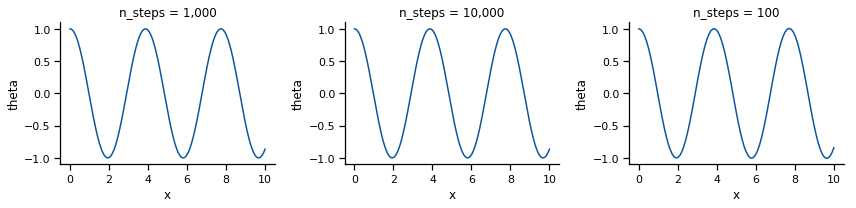

In [87]:
theta1 = y1[:,0]
theta2 = y2[:,0]
theta3 = y3[:,0]

sns.set_palette('Blues_r')
fig, axes = plt.subplots(1, 3, figsize=(12,3))
axes[0].set_title('n_steps = 1,000')
axes[1].set_title('n_steps = 10,000')
axes[2].set_title('n_steps = 100')
axes[0].plot(x1, theta1)
axes[1].plot(x2, theta2)
axes[2].plot(x3, theta3)
for i, ax in enumerate(axes):
    ax.set_xlabel('x')
    ax.set_ylabel('theta')
    ax.set_ylim(axes[0].get_ylim())
sns.despine(fig)
fig.tight_layout()
theta1[-1], theta2[-1], theta3[-1]

6. Conservation of energy implies that the values of $\theta$ should not go beyond the range [-1, 1]. After checking the min and max values of $\hat\theta$ from each numerical simulation, the results are very close to this range. However, they do extend beyond this range by a small amount when using 1,000 or 100 steps. The violation of conservation of energy is more severe with fewer steps, highlighting the importance of numerical accuracy and convergence when simulating physical quantities.

In [162]:
[
    (theta1.min(), theta1.max()),
    (theta2.min(), theta2.max()),
    (theta3.min(), theta3.max())
]

[(-1.0000084339696147, 1.0),
 (-0.9999999848264922, 1.0),
 (-1.0065750163242753, 1.006641774536307)]

# Exercise 6 - Stability

The purpose of this exercise is 

1. For this exercise, I reused the ODE solver methods I implemented earlier.

2. I used the forward Euler method to solve the exponential sample ODE from earlier over the interval $[0, 20]$ with initial conditions $y(0)=20$, using a range of different numbers of steps. I plotted the computed solutions on the same graph and added a legend and color palette to highlight the effect of step size on the estimated solution properties. As the step size became larger, the numerical solution started to wobble and produce inaccurate results, indicating the onset of instability.

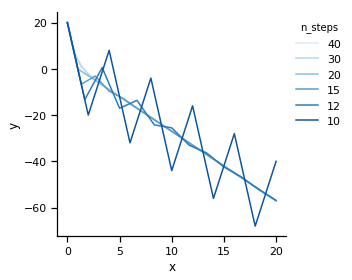

In [118]:
x_range = [0, 20]
y_init = 20

sns.set_palette('Blues', 6)
fig, ax = plt.subplots(figsize=(5,4))

# compute the numerical solutions
for n_steps in [40, 30, 20, 15, 12, 10]:
    x, y = forward_euler(expm_ode, x_range, y_init, n_steps)
    ax.plot(x, y, label=f'{n_steps}')

ax.legend(title='n_steps', frameon=False, loc='upper left', bbox_to_anchor=(1,1))
ax.set_xlabel('x')
ax.set_ylabel('y')
sns.despine(fig)
fig.tight_layout()

3. I repeated this experiment using the RK3 algorithm and adding an additional solution for 8 steps. I plotted all the computed solutions on the same plot to make comparisons easier. Using RK3, the numerical solutions were stable for a broader range of step sizes. However, by reducing the step size further, the solutions became unstable.

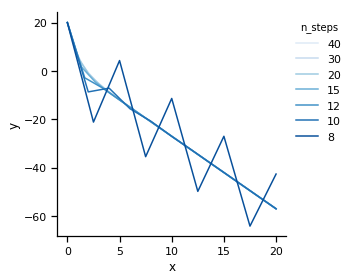

In [119]:
sns.set_palette('Blues', 7)
fig, ax = plt.subplots(figsize=(5,4))

# compute the numerical solutions
for n_steps in [40, 30, 20, 15, 12, 10, 8]:
    x, y = rk3(expm_ode, x_range, y_init, n_steps)
    ax.plot(x, y, label=f'{n_steps}')

ax.legend(title='n_steps', frameon=False, loc='upper left', bbox_to_anchor=(1,1))
ax.set_xlabel('x')
ax.set_ylabel('y')
sns.despine(fig)
fig.tight_layout()

# Exercise 7 - Adams-Bashforth methods

The purpose of this exercise is to consider a different approach to improving the convergence behavior of an ODE solver beyond increasing the number of auxiliary points we compute to estimate the next point. Adams-Bashforth methods make use of previously computed derivative values, and interpolate these with the newly computed derivative values. The solver formula is as follows:

$$
    y_{k+1} = y_k + h\frac{3y'(x_k, y_k) - y'(x_{k-1}, y_{k-1})}{2}
$$

Note the equivalent form:

$$
    y_{k+1} = y_k + h \left( y'(x_k, y_k) + \frac{y'(x_k, y_k) - y'(x_{k-1}, y_{k-1})}{2} \right)
$$

The term inside the parentheses resembles a backward difference equation for the function `y'`, which could be interpretted as incorporating an approximation of the local 2nd order derivative (curvature) of `y` into the numerical solution.

1. I implemented a second-order Adams-Bashforth solver function `ab2`. The function introduces a variable `f_val` that contains the derivative at the current x position. At the end of each iteration, the value of `f_val` is copied to `f_val_prev` so that each iteration after the first has access to the previous derivative value. These are then interpolated together to estimate the next point without computing any auxiliary points. On the first step, when no previous derivative has been defined yet, the estimate is produced using a standard RK2 procedure, which involves 2 derivative computations. When using 100 steps, this function calls the derivative function `f_ode` exactly $1(2) + 99(1) = 101$ times.

In [129]:
def ab2(f_ode, x_range, y_init, n_steps):
    '''
    Use Adams-Bashforth second-order method to solve
    a system of first-order ODEs y' = f_ode(x, y).
    
    Input:
        f_ode = evaluates the righthand side of the ODE
        x_range = [x1, x2] where the solution is sought
            x1 <= x <= x2
        y_init = vector of initial values y(x1)
        n_steps = number of steps across x_range
    Output:
        x = a vector of values of x
        y = a matrix of computed solution at x
    '''
    # initialize arrays to store x and y values
    x = np.zeros(n_steps+1)
    y = np.zeros((n_steps+1, np.size(y_init)))
    
    # get the step size
    h = (x_range[1] - x_range[0]) / n_steps
    
    # compute numerical solution
    for k in range(0, n_steps+1):
        
        if k == 0: # set initial conditions
            x[0] = x_range[0]
            y[0] = y_init
    
        elif k == 1: # perform an RK2 step            
            f_val = f_ode(x[k-1], y[k-1])
            
            # the x and y coordinates a half-step forward
            x_a = x[k-1] + h/2
            y_a = y[k-1] + h/2 * f_val
            f_val_a = f_ode(x_a, y_a)
            
            # use the halfstep derivative to estimate full step
            x[k] = x[k-1] + h
            y[k] = y[k-1] + h*f_val_a

        else: # interpolate derivatives
            f_val_prev = f_val
            f_val = f_ode(x[k-1], y[k-1])
            x[k] = x[k-1] + h
            y[k] = y[k-1] + h*(3*f_val - f_val_prev)/2

    return x, y

2. I used this `ab2` ODE solver function to run another numerical experiment on the sample ODE `expm_ode`. I solved the ODE on the x range $[0,2]$ with initial conditions $y(0)=1$, and I evaluated a random of different step sizes. I recorded the final estimate $\hat{y}(2)$, the error, and the error ratio for each step size. I reported these values in the table below.

In [130]:
# setup grid and initial conditions
x_range = [0.0, 2.0]
y_init = 1.0

# compute the numerical solutions
for k, n_steps in enumerate(df.n_steps):
    x, y = ab2(expm_ode, x_range, y_init, n_steps)
    df.loc[k, 'y_ab2'] = y[-1]

# compute error and error ratios
df['e_ab2'] = (expm_exact(x=x_range[1]) - df['y_ab2']).abs()
df['r_ab2'] = df['e_ab2'] / df['e_ab2'].shift(-1)

df[['n_steps', 'step_size', 'y_ab2', 'e_ab2', 'r_ab2']] # show the table

,n_steps,step_size,y_ab2,e_ab2,r_ab2
k,,,,,
0,10,0.20000,-3.280140,0.009469,4.085396
1,20,0.10000,-3.272988,0.002318,4.051942
2,40,0.05000,-3.271243,0.000572,4.028076
3,80,0.02500,-3.270813,0.000142,4.014531
4,160,0.01250,-3.270706,0.000035,4.007384
5,320,0.00625,-3.270679,0.000009,NaN


4. Based on the error ratios above, I estimated the order of accuracy of the second-order Adams-Bashforth solver as 2. This indicates that the AB2 solver has quadratic convergence behavior, which is on par with the RK2 solver. However, RK2 computes an auxiliary point at each step, resulting in two derivative evaluations per step. The AB2 method only computes an auxiliary point on first step, which becomes amortized as the number of steps increases. Therefore, the AB2 solver achieves roughly the same order of accuracy as RK2 in half the number of derivative calculations, so it is twice as computationally efficient.

In [131]:
# estimate p in error = O(h^p)
# i.e. the order of accuracy, an integer
p_ab2 = np.log2(df['r_ab2'].mean())
p_ab2

2.013450122306037